In [2]:
%pylab nbagg
from tvb.simulator.lab import *
from sklearn.ensemble import ExtraTreesRegressor
import operator
from scipy.signal import butter, lfilter
import scipy
import sim
import pickle
import copy
import os.path

Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


In [3]:
#Data management stuff
path = 'Graphs/Nagaraj'
datapath = "Graphs/Nagaraj/data"
result_no = 0

#No guarantees that changing any of the parameters below won't break the code

#Simulation Parameters
dt = 200
runtime = 20000
ic_buffer = 3000
frame_length = 800
valid_action = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#Learning Parameters
#action_weight = 0.8
#gamma = 0.9
iterations = 10


In [31]:
ts, ds, simulation, stimulus = prepare_sim(run = False)

WARNING  File 'hemispheres' not found in ZIP.


In [48]:
con = connectivity.Connectivity(load_default=True)
weighting = np.ones((76))*0 #np.zeros((76))
weighting[9] = np.array([2]) #stimulate rHC and lHC


eqn_t = equations.Sinusoid()               #square wave

eqn_t.parameters["amp"] = 2
eqn_t.parameters["frequency"] = 0.0001

stim = patterns.StimuliRegion(temporal = eqn_t,
                      connectivity = con, 
                      weight = weighting)

#Configure space and time
stim.configure_space()
stim.configure_time(np.arange(0., runtime, heunint.dt))

WARNING  File 'hemispheres' not found in ZIP.


NameError: name 'heunint' is not defined

In [43]:
stimulus

Temporal equation,PulseTrain
Spatial equation,DiscreteEquation
Type,StimuliRegion
Temporal parameters,"{'onset': 0, 'tau': 500, 'T': 1000, 'amp': 2}"
Spatial parameters,{}


<IPython.core.display.Javascript object>


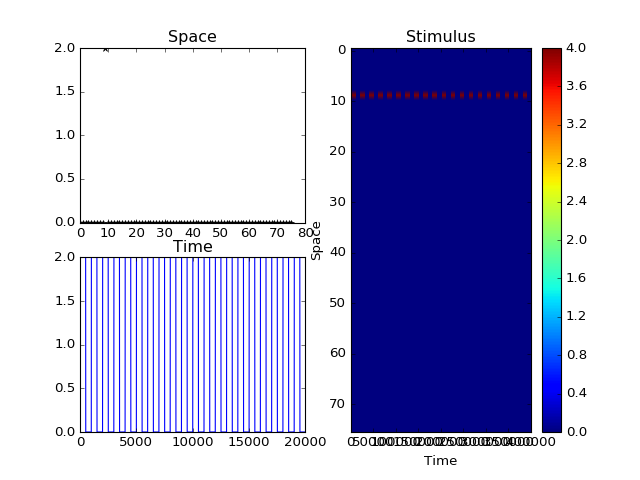

In [38]:
plot_pattern(stimulus)

Analyze the results

In [30]:
def seizure_count(states):

    ictals = []
    past_ict = 0
    ict_len = 0
    ict_lens = []
    for state in states:
        ictal = is_ictal(state)
        ictals.append(ictal)
        if ictal == 1:
            ict_len += 1
        if past_ict == 1 and ictal == 0:
            ict_lens.append(ict_len)
            ict_len = 0
        past_ict = ictal
    if ictal != 0:
        ict_lens.append(ict_len)
        
    
    total_seizures = sum(ictals)
    average_length = sum(ict_lens)/len(ict_lens)
        
    return total_seizures, average_length

In [29]:
stimulus

Temporal equation,Sinusoid
Spatial equation,DiscreteEquation
Type,StimuliRegion
Temporal parameters,"{'amp': 2, 'frequency': 0.0001}"
Spatial parameters,{}


In [20]:
def prepare_sim(run = True): 
    epileptic = [9]
    almost_epileptic = []
    stimulus_target = [9]
    stimulus_amplitude = 2
    stimulus_weight = 2 #0-2 for each region
    onset = 0
    period = 1000
    pulse_width = 500
    frame_length = 800
    ic_buffer = 3000 #buffer for initial conditions
    (s, stimulus) = sim.set_sim(epileptic, almost_epileptic, stimulus_target, stimulus_amplitude, 
                  stimulus_weight, onset, period, pulse_width, runtime)

    t_all = []
    d_all = []
    
    
    if run:
        (t_t, t_d), (aa, aa1), (bb, bb1) = s.run(simulation_length = ic_buffer)
        t_all = copy.copy(t_t)
        d_all = copy.copy(t_d)

    return t_all, d_all, s, stimulus

In [33]:
def run_sim(t_all, d_all, s, stimulus, runtime, dt, valid_action, predictor):
    test_states = []
    action_log = []
    for i in range(runtime/dt):
        if i%20 == 0:
            print "    time: " + str(i*dt)
        if i == 0:
            action_log.append(0)

        (t,d), (aaa, bbb), (ccc,ddd) = s.run(simulation_length = dt)
        t_all = np.append(t_all, t, axis = 0)
        d_all = np.append(d_all, d, axis = 0)

        frame_data = d_all[ ic_buffer + (i+1)*dt - frame_length : ic_buffer + (i+1)*dt ,0,9,0] 
        frame_time = t_all[ ic_buffer + (i+1)*dt - frame_length : ic_buffer + (i+1)*dt ] 

        state = analyze_frame(frame_data, dt, frame_length)

        bestaction = random.choice(valid_action)
        bestval = predictor.predict(append(state, bestaction).reshape(1,-1))[0]

        for action in valid_action:
            val = predictor.predict(append(state, action).reshape(1,-1))[0]
            #print("     Action: " + str(action) + " Value: " + str(val))
            if val > bestval:
                bestaction = action
                bestval = val
        #print "best value is : " + str(bestval) + "\n"
        #print "best action is : " + str(bestaction) + "\n"
        action = bestaction


        action_p = action_params(action)
        T = action_p[0]
        tau = action_p[1]
        amp = action_p[2]

        stimulus.temporal.parameters["amp"] = amp
        stimulus.temporal.parameters["T"] = T
        stimulus.temporal.parameters["tau"] = tau

        test_states.append(state)
        action_log.append(action)
    return t_all, d_all, test_states, action_log

In [34]:
def is_ictal(state):
    if state[3] < 0:
        return 1
    else:
        return 0

In [35]:
def action_params(action):
    if action == 0:
        t = 0
        p = 0
        a = 0
    elif action == 1:
        t = 200
        p = 1
        a = 1
    elif action == 2:
        t = 67
        p = 1
        a = 1
    elif action == 3:
        t = 200
        p = 1
        a = 1.25
    elif action == 4:
        t = 67
        p = 1
        a = 1.25
    elif action == 5:
        t = 200
        p = 1
        a = 1.5
    elif action == 6:
        t = 67
        p = 1
        a = 1.5
    elif action == 7:
        t = 200
        p = 1
        a = 1.75
    elif action == 8:
        t = 67
        p = 1
        a = 1.75
    elif action == 9:
        t = 200
        p = 1
        a = 2
    elif action == 10:
        t = 67
        p = 1
        a = 2
    elif action == 11:
        t = 200
        p = 1
        a = 2.25
    elif action == 12:
        t = 67
        p = 1
        a = 2.25
    elif action == 13:
        t = 200
        p = 1
        a = 2.5
    elif action == 14:
        t = 67
        p = 1
        a = 2.5
    elif action == 15:
        t = 100
        p = 1
        a = 1
    elif action == 16:
        t = 100
        p = 1
        a = 1.25
    elif action == 17:
        t = 100
        p = 1
        a = 1.5
    elif action == 18:
        t = 100
        p = 1
        a = 1.75
    elif action == 19:
        t = 100
        p = 1
        a = 2
    elif action == 20:
        t = 100
        p = 1
        a = 2.25
    elif action == 21:
        t = 100
        p = 1
        a = 2.5
    elif action == 22:
        t = 20
        p = 1
        a = 0.5
    elif action == 23:
        t = 20
        p = 1
        a = 0.75
    elif action == 24:
        t = 20
        p = 1
        a = 1
    elif action == 25:
        t = 10
        p = 1
        a = 0.5
    elif action == 26:
        t = 10
        p = 1
        a = 0.75
    elif action == 27:
        t = 10
        p = 1
        a = 1
     
     
        
    return (t,p,a)


#Import Test Data

In [36]:
def import_data(params):
    ret = []
    for f in params:
        filepath = datapath + f[4] + '.p'
        if os.path.isfile(filepath):
            readfile = open(filepath, 'r')
            in_var = pickle.load(readfile)
            ret.append([in_var[0],in_var[1],in_var[2]])
            
        else:
            print("Not found: " + filepath)
    return ret

#Analyze test set
Use 800 ms frames that move by 200 ms (dt = 200, frame_len = 800)
ictal_log has the same format as action_log, where 1 corresponds to ictal and 0 corresponds to inter-ictal states.

In [37]:
def analyze_frame(d, dt, frame_len):
    data = np.array(d)
    data_sq = square(data)
    data_fft = abs(fft.fft(data))**2/10000
    
    
    #Full
    maxi_long = max(data)
    mini_long = min(data)
    rng_long = maxi_long-mini_long
    avg_long = sum(data)/len(data)
    tot_eng_long = sum(data_fft)
    loF_eng_long = sum(data_fft[:len(data_fft)/3])
    miF_eng_long = sum(data_fft[len(data_fft)/3:2*len(data_fft)/3])
    hiF_eng_long = sum(data_fft[2*len(data_fft)/3:])

    #Half 
    half = len(data)/2
    data_fft_half = abs(fft.fft(data[half:]))
    maxi_half = max(data[half:])
    mini_half = min(data[half:])
    rng_half = maxi_half-mini_half
    avg_half = sum(data[half:])/len(data[half:])
    tot_eng_half = sum(data_fft_half)
    loF_eng_half = sum(data_fft_half[:len(data_fft_half)/3])
    miF_eng_half = sum(data_fft_half[len(data_fft_half)/3:2*len(data_fft_half)/3])
    hiF_eng_half = sum(data_fft_half[2*len(data_fft_half)/3:])


    #Quarter
    qt = 3*len(data)/4
    data_fft_qt = abs(fft.fft(data[qt:]))
    maxi_qt = max(data[qt:])
    mini_qt = min(data[qt:])
    rng_qt = maxi_qt=mini_qt
    avg_qt = sum(data[qt:])/len(data[qt:])
    tot_eng_qt = sum(data_fft_qt)
    loF_eng_qt = sum(data_fft_qt[:len(data_fft_qt)/3])
    miF_eng_qt = sum(data_fft_qt[len(data_fft_qt)/3:2*len(data_fft_qt)/3])
    hiF_eng_qt = sum(data_fft_qt[2*len(data_fft_qt)/3:])


    #Eighth 
    eit = 7*len(data)/8
    data_fft_eit = abs(fft.fft(data[eit:]))
    maxi_eit = max(data[eit:])
    mini_eit = min(data[eit:])
    rng_eit = maxi_eit-mini_eit
    avg_eit = sum(data[eit:])/len(data[eit:])
    tot_eng_eit = sum(data_fft_eit)
    loF_eng_eit = sum(data_fft_eit[:len(data_fft_eit)/3])
    miF_eng_eit = sum(data_fft_eit[len(data_fft_eit)/3:2*len(data_fft_eit)/3])
    hiF_eng_eit = sum(data_fft_eit[2*len(data_fft_eit)/3:])


    state = [
             #stim_T, stim_pw, stim_amp,
             #maxi_long, mini_long, rng_long, avg_long, tot_eng_long, loF_eng_long, miF_eng_long, hiF_eng_long,
             #maxi_half, mini_half, rng_half, avg_half, tot_eng_half, loF_eng_half, miF_eng_half, hiF_eng_half,
             maxi_qt, mini_qt, rng_qt, avg_qt, tot_eng_qt, loF_eng_qt, miF_eng_qt, hiF_eng_qt, 
             maxi_eit, mini_eit, rng_eit, avg_eit, tot_eng_eit, loF_eng_eit, miF_eng_eit, hiF_eng_eit, 
            ]
    return state

In [38]:
def analyze_set(t, d, action_log, ictal_log, dt, time, action_weight = 0.8):
    frame_len = 800
    
    
    n_frames = (time-frame_len)/dt
    
    state_transition = []
    
    #Hand Annotate
#        ictal_log = []
    
    for i in range((n_frames)):
    
        time = t[i*dt:i*dt+frame_len]
        data = np.array(d[i*dt:i*dt+frame_len,0,9,0])
        #ictal = ictal_log[i + frame_len/dt]
        action = action_log[i+frame_len/dt]
        data_sq = square(data)
        data_fft = abs(fft.fft(data))**2/10000
        
        ##HAND ANNOTATE
#        if sum(data[3*len(data)/4:])/len(data[3*len(data)/4:])/len(data[3*len(data)/4:]) < 0:
#            ictal = 1
#        else: ictal = 0
#        ictal_log.append(ictal)
        ##HAND ANNOTATE
        
        
        #Stim
        action_p = action_params(action)
        stim_T = action_p[0]
        stim_pw = action_p[1]
        stim_amp = action_p[2]
        
        #Use analyze_frame instead of this block
        
        #Full
        maxi_long = max(data)
        mini_long = min(data)
        rng_long = maxi_long-mini_long
        avg_long = sum(data)/len(data)
        tot_eng_long = sum(data_fft)
        loF_eng_long = sum(data_fft[:len(data_fft)/3])
        miF_eng_long = sum(data_fft[len(data_fft)/3:2*len(data_fft)/3])
        hiF_eng_long = sum(data_fft[2*len(data_fft)/3:])
        
        #Half 
        half = len(data)/2
        data_fft_half = abs(fft.fft(data[half:]))
        maxi_half = max(data[half:])
        mini_half = min(data[half:])
        rng_half = maxi_half-mini_half
        avg_half = sum(data[half:])/len(data[half:])
        tot_eng_half = sum(data_fft_half)
        loF_eng_half = sum(data_fft_half[:len(data_fft_half)/3])
        miF_eng_half = sum(data_fft_half[len(data_fft_half)/3:2*len(data_fft_half)/3])
        hiF_eng_half = sum(data_fft_half[2*len(data_fft_half)/3:])
        
        
        #Quarter
        qt = 3*len(data)/4
        data_fft_qt = abs(fft.fft(data[qt:]))
        maxi_qt = max(data[qt:])
        mini_qt = min(data[qt:])
        rng_qt = maxi_qt=mini_qt
        avg_qt = sum(data[qt:])/len(data[qt:])
        tot_eng_qt = sum(data_fft_qt)
        loF_eng_qt = sum(data_fft_qt[:len(data_fft_qt)/3])
        miF_eng_qt = sum(data_fft_qt[len(data_fft_qt)/3:2*len(data_fft_qt)/3])
        hiF_eng_qt = sum(data_fft_qt[2*len(data_fft_qt)/3:])
        
        
        #Eighth 
        eit = 7*len(data)/8
        data_fft_eit = abs(fft.fft(data[eit:]))
        maxi_eit = max(data[eit:])
        mini_eit = min(data[eit:])
        rng_eit = maxi_eit-mini_eit
        avg_eit = sum(data[eit:])/len(data[eit:])
        tot_eng_eit = sum(data_fft_eit)
        loF_eng_eit = sum(data_fft_eit[:len(data_fft_eit)/3])
        miF_eng_eit = sum(data_fft_eit[len(data_fft_eit)/3:2*len(data_fft_eit)/3])
        hiF_eng_eit = sum(data_fft_eit[2*len(data_fft_eit)/3:])
        
        
        state = [
                 #stim_T, stim_pw, stim_amp,
                 #maxi_long, mini_long, rng_long, avg_long, tot_eng_long, loF_eng_long, miF_eng_long, hiF_eng_long,
                 #maxi_half, mini_half, rng_half, avg_half, tot_eng_half, loF_eng_half, miF_eng_half, hiF_eng_half,
                 maxi_qt, mini_qt, rng_qt, avg_qt, tot_eng_qt, loF_eng_qt, miF_eng_qt, hiF_eng_qt, 
                 maxi_eit, mini_eit, rng_eit, avg_eit, tot_eng_eit, loF_eng_eit, miF_eng_eit, hiF_eng_eit, 
                ]
        
        action_penalty = 0
        if action != 0:
            action_penalty = -1

        

    
        ictal = is_ictal(state)
        ictal_log.append(ictal)

        reward = - ictal + action_weight * action_penalty
        
        #use previous state in learning
        state_transition.append([state, action, reward])
        
    return state_transition

In [39]:
def fqi(results, dt, time, iterations, action_set, action_weight = 0.8, gamma = 0.9):
    all_transitions = setup_data(results, dt, time)
    
    tree_in = []
    tree_out = []
    nextstate = []
    
    for state_transition in all_transitions:
        for i in range(len(state_transition) - 1):
            if i > 0:
                previous_state = copy.deepcopy(state_transition[i-1][0])
                result_state = copy.deepcopy(state_transition[i][0])
                action_taken = state_transition[i][1]
                reward = state_transition[i][2]
                relative_reward = reward - state_transition[i-1][2]

                state_action = append(previous_state,action_taken)#[previous_state, action] #should they be in a single array?
                out = reward

                tree_in.append(state_action)
                tree_out.append(out)
                nextstate.append(result_state)
                
    predictor = iterate_q(tree_in, tree_out, nextstate,iterations,action_set)
    
    return predictor

#Set up dataset

In [40]:
def setup_data(results,dt,time):
    all_state_transitions = []
    for i in range(len(results)):
        t = results[i][0]
        d = results[i][1]
        a = results[i][2]
        ict = []
        

        s_t = analyze_set(t, d, a, ict, dt, time)
        all_state_transitions.append(s_t)
    return all_state_transitions

#Fitted Q Iteration
Just like Guez did it

In [41]:
def iterate_q(ins, outs, nextstate, iterations, valid_action, gamma = 0.9):
    etrees = ExtraTreesRegressor()
    N = 0;
    print "    iterating Q"
    for x in range(iterations):
        N += 1
        out_new = copy.copy(outs)
        if N > 1:
            for i in range(len(outs)):
                bestaction = random.choice(valid_action)
                
                bestval = etrees.predict(append(nextstate[i], bestaction).reshape(1,-1))
                
                for action in valid_action:
                    val = etrees.predict(append(nextstate[i], action).reshape(1,-1))
                    if val > bestval:
                        bestaction = action
                        bestval = val
                #print ("nextstate: " + str(nextstates[i]) + " best action: " + str(bestaction) + " val: "+str(bestval) )
                out_new[i] += gamma*bestval #gamma = 0.9
        etrees.fit(ins, np.ravel(out_new))
        #if x%(iterations/10.) == 0:
        
        
        
    return etrees

In [42]:
def plot_save_test(t_all, d_all, action_log, test_states, sim_time, dt, filename, result_no, size = (15,10)):
    fig, ax1 = pyplot.subplots(figsize=size)
    ax2 = ax1.twinx()
    ioff()
    ax1.plot(t_all[3000:]-2999.5,d_all[3000:,0,9,0], 'r', label = "Local Field Potential")

    #ax2.plot((t_all[3000:3051]-2999.5)*200, action_log)
    for i in range(sim_time/dt):
        if i == 0:
            timeframe = ax1.plot([i*dt, i*dt], [-3, 3],'g', alpha = 0.1, label = "Frame Start")
        else:
            ax1.plot([i*dt, i*dt], [-3, 3],'g', alpha = 0.1)
    i = 0
    framestart = 0
    stim = 0
    for n in range(len(t_all[3000:])):
        if n % dt == 0 :

            i += 1
            framestart = n
            p = action_params(action_log[i-1])
            period = p[0]
            amp = p[2]
        if  period != 0 and (n - framestart == 0 or (n - framestart) % period ==0 ) :

            if stim == 0:
                ax2.plot([t_all[3000+n]-2999.5, t_all[3000+n]-2999.5], [-amp, amp], 'b', linewidth = 1.5, alpha = 0.5, label = "Stimulus")
                stim += 1
            else:
                ax2.plot([t_all[3000+n]-2999.5, t_all[3000+n]-2999.5], [-amp, amp], 'b', linewidth = 1.5, alpha = 0.5)
    title("Neurostimulation with Offline Reinforcement Learning \n" + filename)


    red = matplotlib.patches.Patch(color='red', label = 'LFP')
    blue = matplotlib.patches.Patch(color='blue', label = 'Stimulus')
    green = matplotlib.patches.Patch(color='green',alpha=0.3, label = 'Frame Start')

    legend(handles=[red,blue,green])


    #show()

    
    fig.savefig(path + "result-" + filename + str(result_no))
    savefile = open(path + "result-" + filename + str(result_no)+'.p','w')
    pickle.dump((t_all, d_all, action_log, test_states), savefile)